<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S8%5CS8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S8/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from config import ModelConfig
#from model import Net
from resnet import ResNet18
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 1e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm

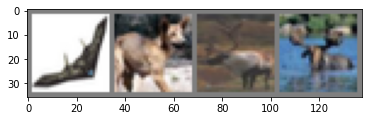

In [2]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, device,(3,32,32))

In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
scheduler = StepLR(optimizer, step_size=35, gamma=0.1)


def test(model, device, test_loader, criterion, classes, test_losses, test_accs, misclassified_imgs,  correct_imgs,is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc > 85.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay)
      scheduler.step()
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs

Let us show some of the training images, for fun.



In [6]:
# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)



  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.50634765625 L1_loss=109338.1015625 Loss=1.169995665550232 Batch_id=781 Accuracy=68.42: 100%|██████████| 782/782 [00:52<00:00, 14.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0140, Accuracy: 6883/10000 (68.83%)

EPOCH: 2


L2_loss=459.7605895996094 L1_loss=109311.9765625 Loss=0.8493028879165649 Batch_id=781 Accuracy=76.42: 100%|██████████| 782/782 [00:53<00:00, 14.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0141, Accuracy: 6985/10000 (69.85%)

EPOCH: 3


L2_loss=460.0030822753906 L1_loss=109296.5078125 Loss=1.1384871006011963 Batch_id=781 Accuracy=81.12: 100%|██████████| 782/782 [00:52<00:00, 14.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0098, Accuracy: 7833/10000 (78.33%)

EPOCH: 4


L2_loss=460.26446533203125 L1_loss=109297.921875 Loss=0.9066341519355774 Batch_id=781 Accuracy=84.31: 100%|██████████| 782/782 [00:52<00:00, 14.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0113, Accuracy: 7627/10000 (76.27%)

EPOCH: 5


L2_loss=460.5411376953125 L1_loss=109311.25 Loss=0.923222541809082 Batch_id=781 Accuracy=87.10: 100%|██████████| 782/782 [00:52<00:00, 14.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 7830/10000 (78.30%)

EPOCH: 6


L2_loss=460.8095397949219 L1_loss=109330.046875 Loss=1.2926305532455444 Batch_id=781 Accuracy=89.81: 100%|██████████| 782/782 [00:52<00:00, 14.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 7878/10000 (78.78%)

EPOCH: 7


L2_loss=461.07232666015625 L1_loss=109358.09375 Loss=1.0852618217468262 Batch_id=781 Accuracy=91.60: 100%|██████████| 782/782 [00:52<00:00, 14.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0102, Accuracy: 7972/10000 (79.72%)

EPOCH: 8


L2_loss=461.2984619140625 L1_loss=109380.6484375 Loss=1.085433840751648 Batch_id=781 Accuracy=93.17: 100%|██████████| 782/782 [00:52<00:00, 14.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0114, Accuracy: 7811/10000 (78.11%)

EPOCH: 9


L2_loss=461.4778137207031 L1_loss=109395.3515625 Loss=0.7319624423980713 Batch_id=781 Accuracy=94.49: 100%|██████████| 782/782 [00:52<00:00, 14.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 8109/10000 (81.09%)

EPOCH: 10


L2_loss=461.605712890625 L1_loss=109395.5546875 Loss=0.7770487666130066 Batch_id=781 Accuracy=95.49: 100%|██████████| 782/782 [00:52<00:00, 14.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 8022/10000 (80.22%)

EPOCH: 11


L2_loss=461.69586181640625 L1_loss=109384.5703125 Loss=1.0840718746185303 Batch_id=781 Accuracy=96.31: 100%|██████████| 782/782 [00:52<00:00, 14.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0101, Accuracy: 8167/10000 (81.67%)

EPOCH: 12


L2_loss=461.75360107421875 L1_loss=109372.3515625 Loss=0.7869982719421387 Batch_id=781 Accuracy=96.87: 100%|██████████| 782/782 [00:52<00:00, 14.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 8267/10000 (82.67%)

EPOCH: 13


L2_loss=461.7472229003906 L1_loss=109336.609375 Loss=0.9650111198425293 Batch_id=781 Accuracy=97.56: 100%|██████████| 782/782 [00:53<00:00, 14.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0116, Accuracy: 8097/10000 (80.97%)

EPOCH: 14


L2_loss=461.7067565917969 L1_loss=109288.9453125 Loss=0.5969821214675903 Batch_id=781 Accuracy=97.98: 100%|██████████| 782/782 [00:56<00:00, 13.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 8219/10000 (82.19%)

EPOCH: 15


L2_loss=461.6307067871094 L1_loss=109233.3359375 Loss=0.7299890518188477 Batch_id=781 Accuracy=98.25: 100%|██████████| 782/782 [00:54<00:00, 14.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 8289/10000 (82.89%)

EPOCH: 16


L2_loss=461.4961242675781 L1_loss=109159.09375 Loss=0.5829204320907593 Batch_id=781 Accuracy=98.64: 100%|██████████| 782/782 [00:54<00:00, 14.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 8213/10000 (82.13%)

EPOCH: 17


L2_loss=461.37957763671875 L1_loss=109091.359375 Loss=0.7732181549072266 Batch_id=781 Accuracy=98.64: 100%|██████████| 782/782 [00:55<00:00, 14.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 8262/10000 (82.62%)

EPOCH: 18


L2_loss=461.2503356933594 L1_loss=109020.2734375 Loss=0.8362361192703247 Batch_id=781 Accuracy=98.82: 100%|██████████| 782/782 [00:55<00:00, 14.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 8289/10000 (82.89%)

EPOCH: 19


L2_loss=461.0821838378906 L1_loss=108937.96875 Loss=0.6900278329849243 Batch_id=781 Accuracy=99.02: 100%|██████████| 782/782 [00:54<00:00, 14.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 8268/10000 (82.68%)

EPOCH: 20


L2_loss=460.8670654296875 L1_loss=108834.5390625 Loss=0.7091653943061829 Batch_id=781 Accuracy=99.26: 100%|██████████| 782/782 [00:55<00:00, 13.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0113, Accuracy: 8291/10000 (82.91%)

EPOCH: 21


L2_loss=460.66717529296875 L1_loss=108739.2578125 Loss=0.6204402446746826 Batch_id=781 Accuracy=99.23: 100%|██████████| 782/782 [00:55<00:00, 14.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 8398/10000 (83.98%)

EPOCH: 22


L2_loss=460.4046936035156 L1_loss=108621.421875 Loss=0.5755784511566162 Batch_id=781 Accuracy=99.50: 100%|██████████| 782/782 [00:54<00:00, 14.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0107, Accuracy: 8418/10000 (84.18%)

EPOCH: 23


L2_loss=460.12188720703125 L1_loss=108494.15625 Loss=0.7550384998321533 Batch_id=781 Accuracy=99.61: 100%|██████████| 782/782 [00:55<00:00, 14.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0109, Accuracy: 8390/10000 (83.90%)

EPOCH: 24


L2_loss=459.88397216796875 L1_loss=108382.8359375 Loss=0.7758132815361023 Batch_id=781 Accuracy=99.53: 100%|██████████| 782/782 [00:55<00:00, 14.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 8357/10000 (83.57%)

EPOCH: 25


L2_loss=459.6399841308594 L1_loss=108274.5 Loss=0.6021867394447327 Batch_id=781 Accuracy=99.45: 100%|██████████| 782/782 [00:54<00:00, 14.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0107, Accuracy: 8416/10000 (84.16%)

EPOCH: 26


L2_loss=459.3453063964844 L1_loss=108142.6328125 Loss=0.5730124115943909 Batch_id=781 Accuracy=99.66: 100%|██████████| 782/782 [00:54<00:00, 14.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 8419/10000 (84.19%)

EPOCH: 27


L2_loss=458.99932861328125 L1_loss=107997.7421875 Loss=0.5770604610443115 Batch_id=781 Accuracy=99.82: 100%|██████████| 782/782 [00:54<00:00, 14.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0108, Accuracy: 8432/10000 (84.32%)

EPOCH: 28


L2_loss=458.6391296386719 L1_loss=107843.84375 Loss=0.5669453144073486 Batch_id=781 Accuracy=99.91: 100%|██████████| 782/782 [00:53<00:00, 14.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0107, Accuracy: 8483/10000 (84.83%)

EPOCH: 29


L2_loss=458.2638244628906 L1_loss=107686.7890625 Loss=0.5701011419296265 Batch_id=781 Accuracy=99.95: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 8499/10000 (84.99%)

EPOCH: 30


L2_loss=457.88543701171875 L1_loss=107527.0703125 Loss=0.5721454620361328 Batch_id=781 Accuracy=99.97: 100%|██████████| 782/782 [00:53<00:00, 14.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 86 %
Accuracy of  bird : 85 %
Accuracy of   cat : 75 %
Accuracy of  deer : 85 %
Accuracy of   dog : 76 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0105, Accuracy: 8554/10000 (85.54%)

EPOCH: 31


L2_loss=457.5184326171875 L1_loss=107369.78125 Loss=0.5671532154083252 Batch_id=781 Accuracy=99.94: 100%|██████████| 782/782 [00:54<00:00, 14.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0117, Accuracy: 8440/10000 (84.40%)

EPOCH: 32


L2_loss=457.1335144042969 L1_loss=107210.921875 Loss=0.5645573735237122 Batch_id=781 Accuracy=99.96: 100%|██████████| 782/782 [00:53<00:00, 14.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 84 %
Accuracy of  bird : 81 %
Accuracy of   cat : 69 %
Accuracy of  deer : 82 %
Accuracy of   dog : 80 %
Accuracy of  frog : 86 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0103, Accuracy: 8532/10000 (85.32%)

EPOCH: 33


L2_loss=456.7615051269531 L1_loss=107053.8515625 Loss=0.5658083558082581 Batch_id=781 Accuracy=99.96: 100%|██████████| 782/782 [00:53<00:00, 14.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 91 %
Accuracy of  bird : 77 %
Accuracy of   cat : 62 %
Accuracy of  deer : 85 %
Accuracy of   dog : 82 %
Accuracy of  frog : 87 %
Accuracy of horse : 92 %
Accuracy of  ship : 98 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0109, Accuracy: 8508/10000 (85.08%)

EPOCH: 34


L2_loss=456.3709411621094 L1_loss=106893.4609375 Loss=0.5690343379974365 Batch_id=781 Accuracy=99.97: 100%|██████████| 782/782 [00:54<00:00, 14.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 73 %
Accuracy of   car : 83 %
Accuracy of  bird : 78 %
Accuracy of   cat : 76 %
Accuracy of  deer : 87 %
Accuracy of   dog : 75 %
Accuracy of  frog : 92 %
Accuracy of horse : 87 %
Accuracy of  ship : 89 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0104, Accuracy: 8505/10000 (85.05%)

EPOCH: 35


L2_loss=455.9761657714844 L1_loss=106729.609375 Loss=0.587737500667572 Batch_id=781 Accuracy=99.99: 100%|██████████| 782/782 [00:53<00:00, 14.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 93 %
Accuracy of  bird : 86 %
Accuracy of   cat : 60 %
Accuracy of  deer : 85 %
Accuracy of   dog : 89 %
Accuracy of  frog : 88 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0104, Accuracy: 8511/10000 (85.11%)

EPOCH: 36


L2_loss=455.9354248046875 L1_loss=106712.890625 Loss=0.5672817230224609 Batch_id=781 Accuracy=99.99: 100%|██████████| 782/782 [00:53<00:00, 14.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 98 %
Accuracy of  bird : 73 %
Accuracy of   cat : 67 %
Accuracy of  deer : 77 %
Accuracy of   dog : 87 %
Accuracy of  frog : 94 %
Accuracy of horse : 87 %
Accuracy of  ship : 90 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0105, Accuracy: 8541/10000 (85.41%)

EPOCH: 37


L2_loss=455.89453125 L1_loss=106696.3125 Loss=0.5630928874015808 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 80 %
Accuracy of   cat : 86 %
Accuracy of  deer : 83 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 88 %
Accuracy of  ship : 89 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0101, Accuracy: 8570/10000 (85.70%)

EPOCH: 38


L2_loss=455.85394287109375 L1_loss=106679.7578125 Loss=0.5671119689941406 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:53<00:00, 14.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 92 %
Accuracy of  bird : 90 %
Accuracy of   cat : 57 %
Accuracy of  deer : 85 %
Accuracy of   dog : 76 %
Accuracy of  frog : 93 %
Accuracy of horse : 86 %
Accuracy of  ship : 92 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0103, Accuracy: 8539/10000 (85.39%)

EPOCH: 39


L2_loss=455.8133239746094 L1_loss=106663.203125 Loss=0.5681571960449219 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:53<00:00, 14.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 94 %
Accuracy of  bird : 71 %
Accuracy of   cat : 68 %
Accuracy of  deer : 87 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 84 %
Accuracy of  ship : 93 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0103, Accuracy: 8559/10000 (85.59%)

EPOCH: 40


L2_loss=455.77276611328125 L1_loss=106646.625 Loss=0.5637879371643066 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 93 %
Accuracy of  bird : 64 %
Accuracy of   cat : 61 %
Accuracy of  deer : 84 %
Accuracy of   dog : 80 %
Accuracy of  frog : 92 %
Accuracy of horse : 83 %
Accuracy of  ship : 90 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0102, Accuracy: 8591/10000 (85.91%)

EPOCH: 41


L2_loss=455.7322082519531 L1_loss=106630.0703125 Loss=0.5638036727905273 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:53<00:00, 14.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 89 %
Accuracy of  bird : 72 %
Accuracy of   cat : 66 %
Accuracy of  deer : 88 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 90 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0100, Accuracy: 8545/10000 (85.45%)

EPOCH: 42


L2_loss=455.69140625 L1_loss=106613.5 Loss=0.5627735257148743 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 90 %
Accuracy of  bird : 75 %
Accuracy of   cat : 65 %
Accuracy of  deer : 85 %
Accuracy of   dog : 77 %
Accuracy of  frog : 96 %
Accuracy of horse : 86 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0103, Accuracy: 8542/10000 (85.42%)

EPOCH: 43


L2_loss=455.6506652832031 L1_loss=106596.9453125 Loss=0.5642940998077393 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:55<00:00, 14.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 79 %
Accuracy of   cat : 71 %
Accuracy of  deer : 83 %
Accuracy of   dog : 76 %
Accuracy of  frog : 84 %
Accuracy of horse : 90 %
Accuracy of  ship : 96 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0105, Accuracy: 8554/10000 (85.54%)

EPOCH: 44


L2_loss=455.60986328125 L1_loss=106580.3671875 Loss=0.562507688999176 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 73 %
Accuracy of   cat : 66 %
Accuracy of  deer : 81 %
Accuracy of   dog : 80 %
Accuracy of  frog : 86 %
Accuracy of horse : 89 %
Accuracy of  ship : 85 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0104, Accuracy: 8564/10000 (85.64%)

EPOCH: 45


L2_loss=455.5690612792969 L1_loss=106563.8203125 Loss=0.5646012425422668 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:55<00:00, 13.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 95 %
Accuracy of   car : 95 %
Accuracy of  bird : 75 %
Accuracy of   cat : 65 %
Accuracy of  deer : 70 %
Accuracy of   dog : 77 %
Accuracy of  frog : 83 %
Accuracy of horse : 81 %
Accuracy of  ship : 95 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0102, Accuracy: 8576/10000 (85.76%)

EPOCH: 46


L2_loss=455.5283508300781 L1_loss=106547.2421875 Loss=0.5647305846214294 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 91 %
Accuracy of  bird : 72 %
Accuracy of   cat : 73 %
Accuracy of  deer : 77 %
Accuracy of   dog : 79 %
Accuracy of  frog : 88 %
Accuracy of horse : 92 %
Accuracy of  ship : 89 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0106, Accuracy: 8536/10000 (85.36%)

EPOCH: 47


L2_loss=455.4875183105469 L1_loss=106530.6875 Loss=0.5623100399971008 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 95 %
Accuracy of  bird : 75 %
Accuracy of   cat : 73 %
Accuracy of  deer : 79 %
Accuracy of   dog : 78 %
Accuracy of  frog : 87 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0104, Accuracy: 8529/10000 (85.29%)

EPOCH: 48


L2_loss=455.4466552734375 L1_loss=106514.125 Loss=0.5620714426040649 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 90 %
Accuracy of  bird : 85 %
Accuracy of   cat : 75 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 92 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 89 %

Test set: Average loss: 0.0103, Accuracy: 8563/10000 (85.63%)

EPOCH: 49


L2_loss=455.40582275390625 L1_loss=106497.5546875 Loss=0.5621033906936646 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [01:01<00:00, 12.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 87 %
Accuracy of  bird : 71 %
Accuracy of   cat : 62 %
Accuracy of  deer : 90 %
Accuracy of   dog : 74 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 90 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0102, Accuracy: 8539/10000 (85.39%)

EPOCH: 50


L2_loss=455.3650207519531 L1_loss=106481.015625 Loss=0.5666463375091553 Batch_id=781 Accuracy=100.00: 100%|██████████| 782/782 [00:54<00:00, 14.28it/s]



Accuracy of plane : 88 %
Accuracy of   car : 91 %
Accuracy of  bird : 76 %
Accuracy of   cat : 75 %
Accuracy of  deer : 88 %
Accuracy of   dog : 75 %
Accuracy of  frog : 81 %
Accuracy of horse : 89 %
Accuracy of  ship : 92 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0103, Accuracy: 8585/10000 (85.85%)



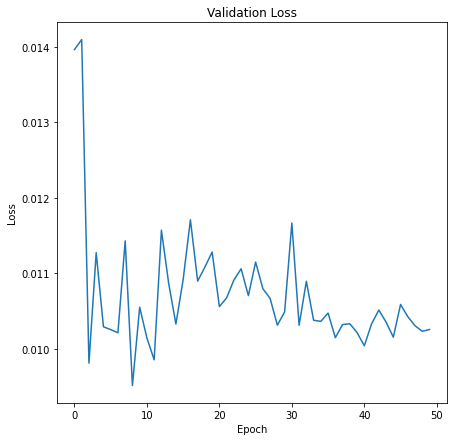

In [7]:
plot_graph(test_losses, "Loss")



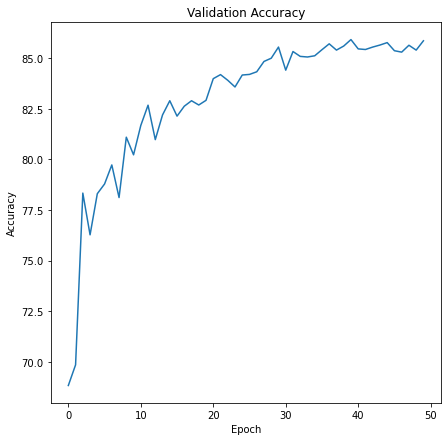

In [8]:
plot_graph(test_accs, "Accuracy")



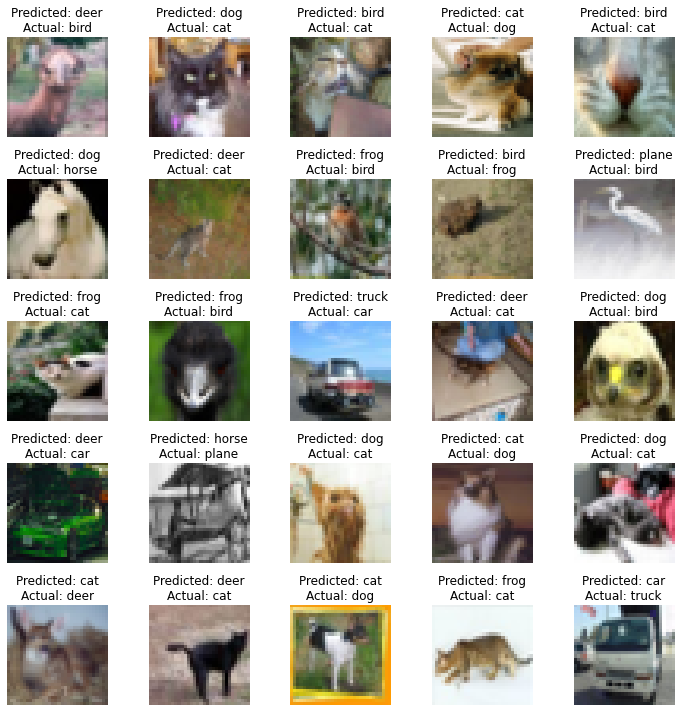

In [9]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")
